# **PFE : Tracking**

### **Importation des librairies**

In [1]:
import platform
print(platform.architecture())
print(platform.python_version())


('64bit', 'WindowsPE')
3.10.0


In [ ]:
from PytorchWildlife.models import detection as pw_detection
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Importations Pytorch
import torch
import torch.optim as optim
from torch.amp import GradScaler, autocast
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
from torchvision import datasets
from torch.utils.data import DataLoader, Dataset, ConcatDataset, WeightedRandomSampler, TensorDataset
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
import torchvision.transforms as transforms

import onnx 
import onnxruntime
from onnxsim import simplify
%matplotlib inline 

### **Chargement du modèle EfficientNet**

In [2]:
# Charger le modèle EfficientNet-B0 pré-entraîné
model_efficientnet = models.efficientnet_b7(pretrained=True)

# Modifier la dernière couche pour le nombre de classes souhaité
num_classes = 6
model_efficientnet.classifier[1] = nn.Sequential(
    nn.Linear(model_efficientnet.classifier[1].in_features, num_classes),
    nn.Softmax(dim=1)  # Ajout de Softmax
)
# Envoyer sur GPU si disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_efficientnet = model_efficientnet.to(device)

# Chargement des poids entraînés
efficient_weights = torch.load('efficient_weights.pth', map_location=device)

# On applique ces poids entraînés sur le modèle
model_efficientnet.load_state_dict(efficient_weights)

# Afficher le modèle
# print(model_efficientnet)

# Transformation : pré-traitement des images avant classification 
transform_classification = transforms.Compose([
    transforms.Resize((299, 299)),

transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

])

classes = {
    0: "blaireau",
    1: "chevreuil",
    2: "renard",
    3: "herisson",
    4: "loutre",
    5: "mustelide",
}


### **Chargement du modèle Inception-v3**

In [3]:
inception_model = models.inception_v3(pretrained=True)

# Modifier la dernière couche entièrement connectée pour correspondre au nombre de classes
num_classes = 6
inception_model.fc = nn.Linear(inception_model.fc.in_features, num_classes)

In [4]:
state_dict = torch.load('inception_weights_version2.pth', map_location=device)

# Load the state dictionary into the model
inception_model.load_state_dict(state_dict, strict=False)

<All keys matched successfully>

### **Chargement du modèle de détection (MegaDetector V5)**

In [135]:
from ultralytics import YOLO
from yolov5.models.common import DetectMultiBackend


In [140]:
# Charger le modèle
weights_path = "MegaDetectorV5.pt"

model = torch.load("MegaDetectorV5.pt", map_location='cpu')['model'].float().fuse().eval()


Fusing layers... 
Model summary: 733 layers, 140054656 parameters, 0 gradients, 208.8 GFLOPs


In [153]:
image_path = "Deer.jpg"  # remplace par ton image
img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Redimensionner et normaliser (taille classique pour YOLOv5 = 640)
img_resized = cv2.resize(img_rgb, (640, 640))
img_tensor = torch.from_numpy(img_resized).permute(2, 0, 1).float() / 255.0  # (C,H,W), [0,1]
img_tensor = img_tensor.unsqueeze(0)  # Ajouter dimension batch


In [154]:
with torch.no_grad():
    results = model(img_tensor)[0]


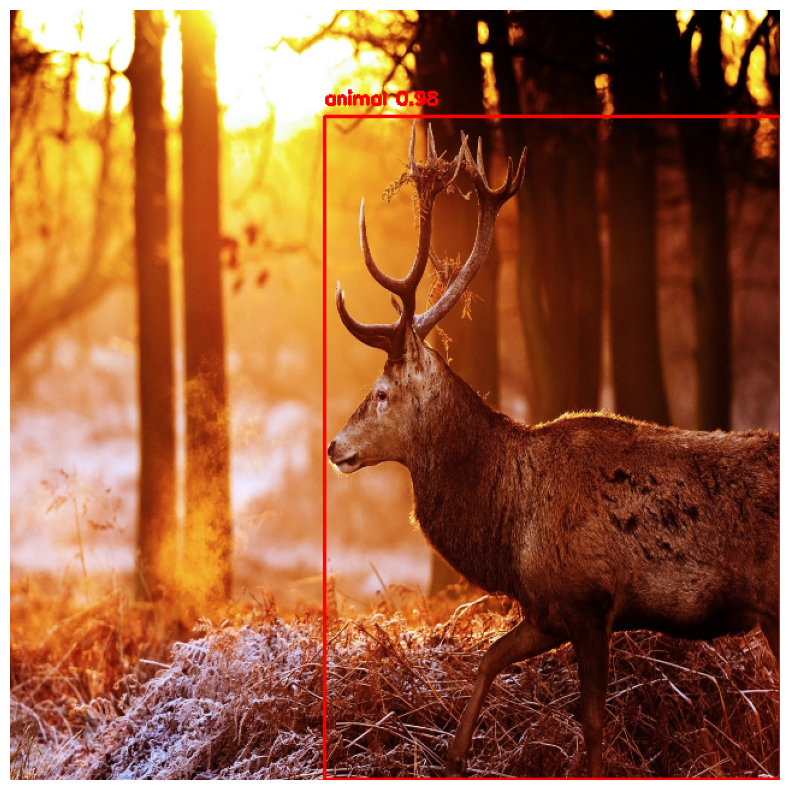

In [159]:
from yolov5.utils.general import non_max_suppression

# Appliquer NMS
detections = non_max_suppression(results, conf_thres=0.25, iou_thres=0.45)[0]

# Dessiner les détections sur l’image redimensionnée (640x640)
for *xyxy, conf, cls in detections:
    label = f"{model.names[int(cls)]} {conf:.2f}"
    cv2.rectangle(img_resized, (int(xyxy[0]), int(xyxy[1])), (int(xyxy[2]), int(xyxy[3])), (255, 0, 0), 2)
    cv2.putText(img_resized, label, (int(xyxy[0]), int(xyxy[1]) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

# Afficher
plt.figure(figsize=(10, 10))
plt.imshow(img_resized)
plt.axis('off')
plt.show()


### ***Trackiiiiinng***

In [6]:
inception_model.eval()

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:


# Ouvrir la vidéo
video_path = "zoo\IMG_0637_1_.mp4"
cap = cv2.VideoCapture(video_path)

# Récupérer les infos de la vidéo
fps = int(cap.get(cv2.CAP_PROP_FPS))
width, height = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')

# Création de la vidéo de sortie avec tracking
out = cv2.VideoWriter("zoo\IMG_0637_1_tracked_bis.mp4", fourcc, fps, (width, height)) 


# Fonction pour calculer l'IoU entre deux bounding boxes
def iou(box1, box2):
    x1, y1, x2, y2 = box1
    x1_p, y1_p, x2_p, y2_p = box2

    xi1, yi1 = max(x1, x1_p), max(y1, y1_p)
    xi2, yi2 = min(x2, x2_p), min(y2, y2_p)
    
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2_p - x1_p) * (y2_p - y1_p)
    
    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area != 0 else 0

# Initialisation des objets suivis
tracked_objects = []
frame_count = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    if frame_count % 5 == 0:  # Réexécuter la détection toutes les 5 frames
        new_detections = detection_model.single_image_detection(np.array(frame))
        new_results = new_detections["detections"]

        new_tracked_objects = []
        for r in range(len(new_results.xyxy)):
            
            # On récupère ici le score de confiance de chacune de détection
            conf = float(new_results.confidence[r])     
            # if conf<0.5 : # Si le score de confiance est inférieur à 0.5, alors on rejette la prédiction
            #     continue
            
            # On récupère les coordonnées de la bounding box prédite. 
            x1, y1, x2, y2 = map(int, new_results.xyxy[r])
            matched = False
            
            # Ici également, on ne retient que les bounding box avec IoU supérieur à 0.5
            for obj in tracked_objects:
                if iou([x1, y1, x2, y2], obj["bbox"]) > 0.5:
                    obj["bbox"] = [x1, y1, x2, y2]
                    obj["confidence"] = conf
                    matched = True
                    new_tracked_objects.append(obj)
                    break
            
            if not matched:
                new_tracked_objects.append({"bbox": [x1, y1, x2, y2], "confidence" : conf})
        
        tracked_objects = new_tracked_objects

    # On dessine alors sur la vidéo de sortie "out" la bounding box
    # for obj in tracked_objects:
    #     x1, y1, x2, y2 = obj["bbox"]
    #     conf = obj["confidence"]
    #     cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)
        
    #     # On y ajoute également le score de confiance pour plus de précision
    #     label = f"{conf:.2f}"
    #     cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
    
    
    for obj in tracked_objects:
        x1, y1, x2, y2 = obj["bbox"]
        conf = obj["confidence"]

        # Affichage du score de détection (comme dans ton code original)
        label = f"{conf:.2f}"
        cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)
        cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

        # Découpe de la zone détectée
        cropped_img = frame[y1:y2, x1:x2]
        if cropped_img.size == 0:
            continue
        print(cropped_img.shape)
        # Prétraitement pour le classifieur (EfficientNet, Inception, ResNet,...)
        img_pil = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)
        img_tensor = transform_classification(transforms.ToPILImage()(img_pil)).unsqueeze(0).to(device)

        # Prédiction de classe
        with torch.no_grad():
            output = inception_model(img_tensor)
            probs = torch.nn.functional.softmax(output, dim=1)
            pred_class = torch.argmax(probs, dim=1).item()
            pred_score = torch.max(probs).item()

        # Nom de classe
        class_name = classes.get(pred_class, "Inconnu")

        # Affichage du nom de la classe et du score de classification
        class_text = f"{class_name} ({pred_score:.2f})"
        cv2.putText(frame, class_text, (x1, y2 + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.55, (0, 255, 0), 2)

    # On renvoit la vidéo de sortie une fois complètement traitée.
    # On peut également voir l'évolution des bounding box lorsque l'on fait tourner le code.
    out.write(frame)
    cv2.imshow("Tracking", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    frame_count += 1

cap.release()
out.release()
cv2.destroyAllWindows()



(141, 102, 3)
(98, 42, 3)
(141, 102, 3)
(98, 42, 3)
(141, 102, 3)
(98, 42, 3)
(141, 102, 3)
(98, 42, 3)
(141, 102, 3)
(98, 42, 3)
(142, 102, 3)
(99, 43, 3)
(142, 102, 3)
(99, 43, 3)
(142, 102, 3)
(99, 43, 3)
(142, 102, 3)
(99, 43, 3)
(142, 102, 3)
(99, 43, 3)
(140, 103, 3)
(98, 43, 3)
(140, 103, 3)
(98, 43, 3)
(140, 103, 3)
(98, 43, 3)
(140, 103, 3)
(98, 43, 3)
(140, 103, 3)
(98, 43, 3)
(141, 103, 3)
(98, 44, 3)
(141, 103, 3)
(98, 44, 3)
(141, 103, 3)
(98, 44, 3)
(141, 103, 3)
(98, 44, 3)
(141, 103, 3)
(98, 44, 3)
(141, 103, 3)
(98, 42, 3)
(141, 103, 3)
(98, 42, 3)
(141, 103, 3)
(98, 42, 3)
(141, 103, 3)
(98, 42, 3)
(141, 103, 3)
(98, 42, 3)
(141, 102, 3)
(98, 44, 3)
(141, 102, 3)
(98, 44, 3)
(141, 102, 3)
(98, 44, 3)
(141, 102, 3)
(98, 44, 3)
(141, 102, 3)
(98, 44, 3)
(142, 103, 3)
(98, 44, 3)
(142, 103, 3)
(98, 44, 3)
(142, 103, 3)
(98, 44, 3)
(142, 103, 3)
(98, 44, 3)
(142, 103, 3)
(98, 44, 3)
(142, 103, 3)
(99, 47, 3)
(142, 103, 3)
(99, 47, 3)
(142, 103, 3)
(99, 47, 3)
(142, 103, 3

KeyboardInterrupt: 